## Comapre RNN fit and time of running across different lengths of training single-trial data

In [1]:
import os
import sys
import glob
import importlib
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA

# pyaldata
sys.path.append("/home/zms24/Desktop") 
import PyalData.pyaldata as pyal # type:ignore

# tools functions
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from tools.curbd import curbd
from tools.dsp.preprocessing import preprocess
from tools.rnn_and_curbd import rnn as rnnz
from tools.rnn_and_curbd import plotting as pltz
from tools.rnn_and_curbd import model_analysis as analyz
from tools.rnn_and_curbd import curbd as curbdz

# Reload modules
importlib.reload(rnnz)
importlib.reload(pltz)
importlib.reload(analyz)
importlib.reload(curbdz)

np.random.seed(61)

### Open RNN model files

In [2]:
data_dir = "/home/zms24/Desktop/rnn_models"
file_names = glob.glob(f"{data_dir}/single_*.mat")
file_names.sort()           

In [3]:
rnn_models = {}
for path in file_names:
    data = loadmat(path, simplify_cells=True)
    rnn_model = data['rnn_model']
    trial_num = path.split('single_')[1].split('_')[0]
    trial_len_sec = f"{4 * int(trial_num)} s"

    rnn_models[trial_len_sec] = rnn_model


### Look at model accuracy

In [10]:
def plot_model_accuracy_by_group(rnn_models):

    fig = plt.figure(figsize=[4, 2], dpi = 300)

    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    for label, model in rnn_models.items():

        pVars = model['pVars']
        chi2s = model['chi2s']
        iterations = np.arange(len(pVars))

        ax1.plot(iterations, pVars, label=label)
        ax2.plot(iterations, chi2s)

    ax1.set_ylim(0, 1)
    ax1.set_ylabel("pVar")
    ax2.set_ylabel("chi2s")
    ax1.set_xlabel("Iterations")
    ax2.set_xlabel("Iterations")

    fig.tight_layout()

    # Extract and sort legend entries by numeric value in label (e.g., "300 s" → 300)
    handles, labels = ax1.get_legend_handles_labels()
    sorted_pairs = sorted(zip(labels, handles), key=lambda x: int(x[0].split()[0]))  # split on space, take first part

    sorted_labels, sorted_handles = zip(*sorted_pairs)

    fig.legend(sorted_handles, sorted_labels, frameon=False, bbox_to_anchor=(1.2, 1))

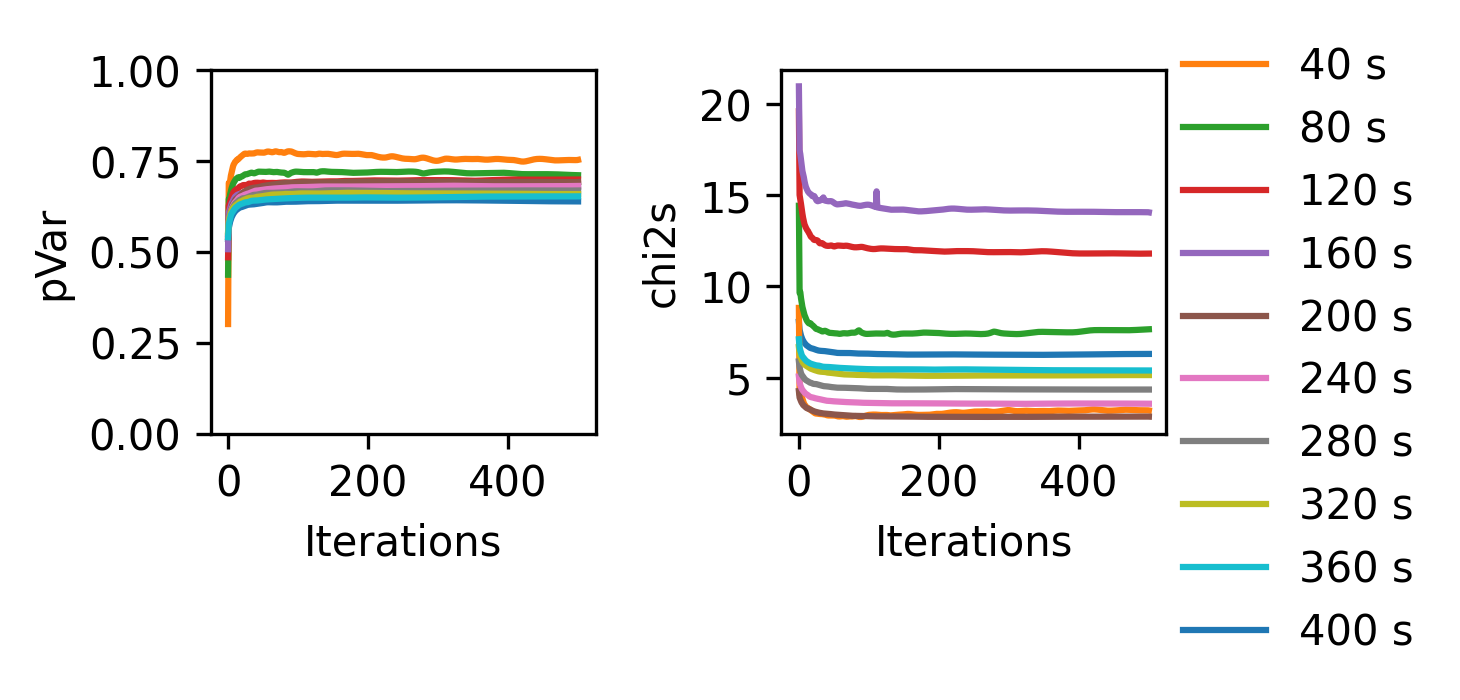

In [11]:
plot_model_accuracy_by_group(rnn_models)

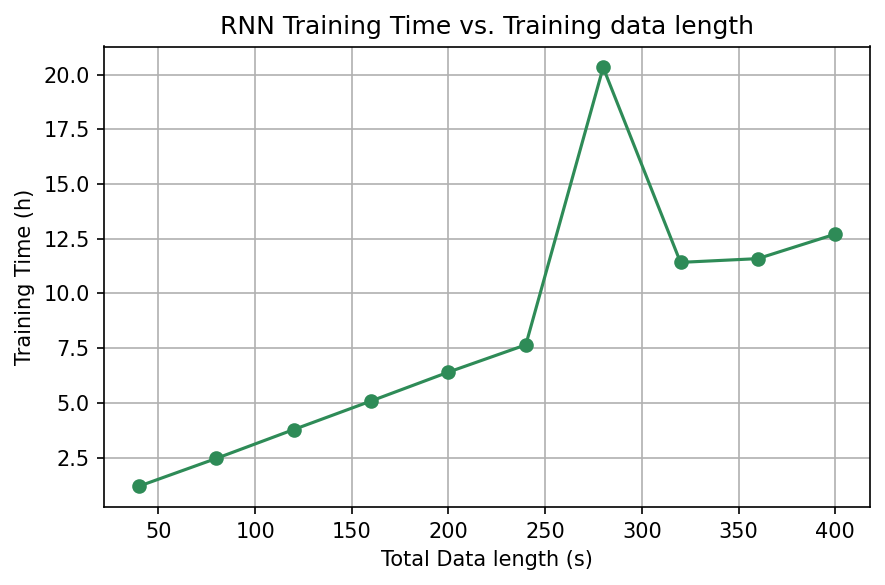

In [16]:
# Read file and skip the title line
with open('/home/zms24/Desktop/rnn_models/rnn_training_time_summary_M062_2025_03_19_14_00.txt', 'r') as f:
    lines = f.readlines()[1:]  # skip the first line

data = []
for line in lines:
    if ':' in line:
        trials_str, time_str = line.strip().split(':')
        num_trials = int(trials_str.split()[0])
        train_time_sec = float(time_str.strip().split()[0])

        trial_duration_hr = (num_trials * 4) # 4 seconds per trial
        train_time_hr = train_time_sec / 3600

        data.append((trial_duration_hr, train_time_hr))

df = pd.DataFrame(data, columns=['data_duration_s', 'training_time_hr'])

# Plot
plt.figure(figsize=(6, 4), dpi=150)
plt.plot(df['data_duration_s'], df['training_time_hr'], marker='o', color='seagreen')
plt.xlabel('Total Data length (s)')
plt.ylabel('Training Time (h)')
plt.title('RNN Training Time vs. Training data length')
plt.grid(True)
plt.tight_layout()
plt.show()